In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# set up data and admin

In [11]:
all_config = {'dataset':'tox21',
            'batch_size':4,    'use_cuda':0}

contextpred_config={
                 'num_layer': 5,
                 'emb_dim': 300,
                 'JK': 'last',
                 'drop_ratio': 0.5,
                 'gnn_type': 'gin'

             }

# all_config['datapath']= datapath
all_config['gnn_config']=contextpred_config
# all_config['checkpoint_dir']=checkpoint_dir

endpoint_list = np.load(f"data/{all_config['dataset']}-endpoints.npy",allow_pickle=True)

head_config = {'input_size': all_config['gnn_config']['emb_dim'],
'hidden_size' : 256,
'output_size' : 2,
'channel_size' :len(endpoint_list),
'batch_size' : all_config['batch_size']}



all_config['head_config']= head_config

In [3]:
train_df = pd.read_csv(f"data/train/{all_config['dataset']}-all.csv") 

In [4]:
train_df.shape

(62353, 3)

# model and opt

In [5]:
from featurizer import featurizer
import torch.nn as nn
import torch


from models import *

In [15]:
model = multi_task_baseline(all_config)

In [9]:
model.w1.shape

torch.Size([12, 256, 300])

# batch-wise

In [10]:
batch=train_df.groupby(['endpoint','y']).sample(n=all_config['batch_size'])
batch_smiles = batch['similes'].values

batch_y = batch['y'].values
batch_target = torch.tensor(batch_y.reshape((12,8)).swapaxes(0,1)).long()

In [30]:
batch.head(10)

,similes,y,endpoint
20887,CN(C)CCc1c[nH]c2ccc(Cn3cncn3)cc12,0.0,NR-AR
21648,O=C(N[C@@H](c1ccccc1)[C@@H]1CCCCN1)c1cccc(C(F)...,0.0,NR-AR
22850,CC(O)C(CO)C(C)O,0.0,NR-AR
22116,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc(OC)ccc4[C@H]3...,0.0,NR-AR
23822,C=C1C[C@@H]2[C@H](CC[C@]3(C)C(=O)CC[C@@H]23)[C...,1.0,NR-AR
25564,O=C(O)C=Cc1ccc(O)c(O)c1,1.0,NR-AR
24929,C[C@]12CC[C@H]3[C@@H](CC[C@H]4C[C@@H]5S[C@@H]5...,1.0,NR-AR
24384,N[C@@H](CCC(=O)N[C@@H](CSSC[C@H](NC(=O)CC[C@H]...,1.0,NR-AR
19725,CCOC(=O)[C@H](CCc1ccccc1)N[C@H]1CCCN2CCC[C@@H]...,0.0,NR-AR-LBD
16839,CCCCCCCCn1cc[n+](C)c1.F[B-](F)(F)F,0.0,NR-AR-LBD


In [29]:
batch['endpoint'].unique()

array(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
       'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE',
       'SR-MMP', 'SR-p53'], dtype=object)

### embedding

In [18]:
x = model.chem_embed(batch_smiles)
mul = model.cal_mul(x)

In [19]:
x.shape,mul.shape

(torch.Size([8, 12, 1, 300]), torch.Size([8, 12, 256]))

# CORE

In [26]:
OOD_ratio = 0.4
pick_OOD = int( all_config['batch_size']*2*OOD_ratio)

In [20]:
mode_set =  mul.mean(0,keepdim=True)[0]

In [21]:
mode_set.shape

torch.Size([12, 256])

In [27]:
# i= 3
ood_enhance_loss = 0
for i in range(len(endpoint_list)):
    #............
    H= mul[:,i,:]
    mode = mode_set[i]
    dist_to_mode = torch.cdist(H, mode.unsqueeze(0))#.............. ploted below
    id_OOD =  torch.argsort(dist_to_mode.squeeze(1),
                            descending=True)[:pick_OOD].detach().numpy().tolist()

    h_ood = H[id_OOD]
    #............
    mo = mode_set.clone()
    mo[i] = torch.tensor([9]*model.w1.shape[1])
    dist_to_other_mode = torch.cdist(h_ood,mo)
    pick_task = dist_to_other_mode.argsort(descending=False)[:,0].detach().numpy().tolist()
    print(f'--------{i}')
    print(pick_task)
    pick_x = x[:,i,:,:][id_OOD].unsqueeze(1)
    pick_w = model.w1[pick_task].unsqueeze(1)
    pick_b = model.b1[:,pick_task].squeeze(0).unsqueeze(1)
    #............
    h_ood_pick=((pick_x * pick_w).sum(-1) + pick_b)
    ood_enhance_loss_i =  torch.dist(h_ood,h_ood_pick.squeeze())
    # print(ood_enhance_loss_i/pick_OOD) 
    ood_enhance_loss += ood_enhance_loss_i/pick_OOD

--------0
[7, 5, 6]
--------1
[2, 5, 5]
--------2
[5, 6, 7]
--------3
[4, 4, 4]
--------4
[3, 6, 9]
--------5
[7, 9, 6]
--------6
[9, 2, 9]
--------7
[10, 2, 4]
--------8
[4, 4, 11]
--------9
[4, 4, 7]
--------10
[5, 9, 7]
--------11
[9, 5, 4]


In [250]:
ood_enhance_loss/len(endpoint_list)

tensor(4.5155, grad_fn=<DivBackward0>)

# ploting

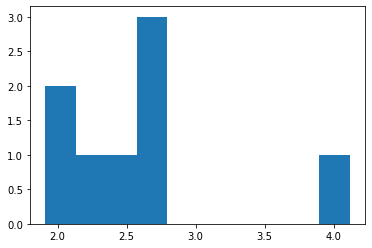

In [67]:
plt.hist(dist_to_mode.detach().numpy())
plt.show()

# TO-DO:independent adapt

In [229]:
grad = torch.autograd.grad(ood_enhance_loss_i,pick_w,allow_unused=True)

In [234]:
grad[0].shape

torch.Size([3, 1, 256, 300])

In [235]:
update_lr=0.0005

In [238]:
fast_w = pick_w - grad[0]*update_lr

# TO-DO: PGI-loss